In [32]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [33]:
df = pd.read_csv('./results/yolo_face_cpu-20220413-192351.tsv', sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/yolo_face_cpu-20220413-192351-ap.tsv', sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/yolo_face_cpu-20220413-192351-load.tsv', sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/yolo_face_cpu-20220413-192351-metadata.tsv', sep='\t', header=0)

In [34]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [35]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-13 19:23:51.745155,2.9,7547633664
1,2022-04-13 19:24:03.084654,66.8,6799650816
2,2022-04-13 19:24:14.172654,34.6,6801944576
3,2022-04-13 19:24:25.348155,67.9,6803222528
4,2022-04-13 19:24:36.657653,68.9,6812585984
...,...,...,...
109,2022-04-13 19:44:27.107653,69.8,6934683648
110,2022-04-13 19:44:38.124153,69.6,6915362816
111,2022-04-13 19:44:49.250654,69.8,6944714752
112,2022-04-13 19:45:00.540155,70.6,6943272960


In [36]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

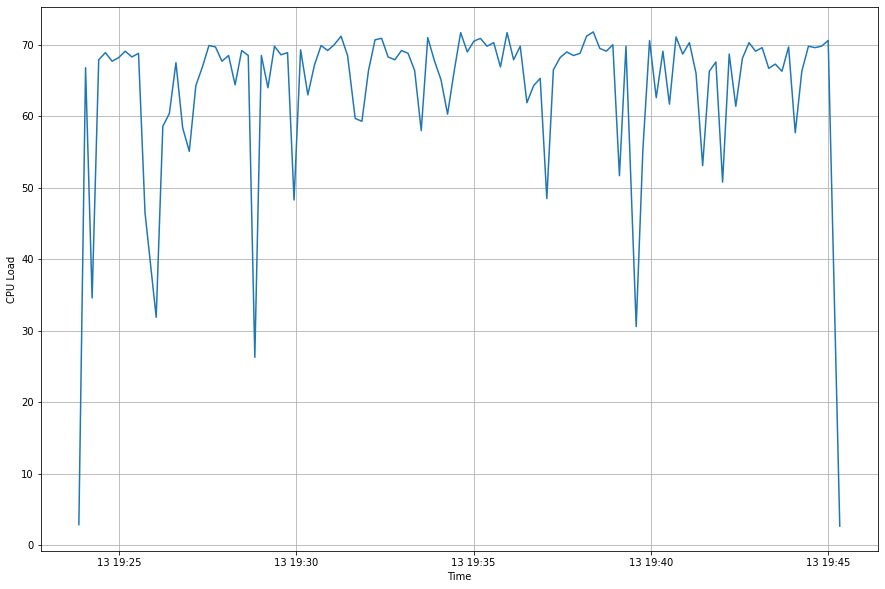

In [37]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

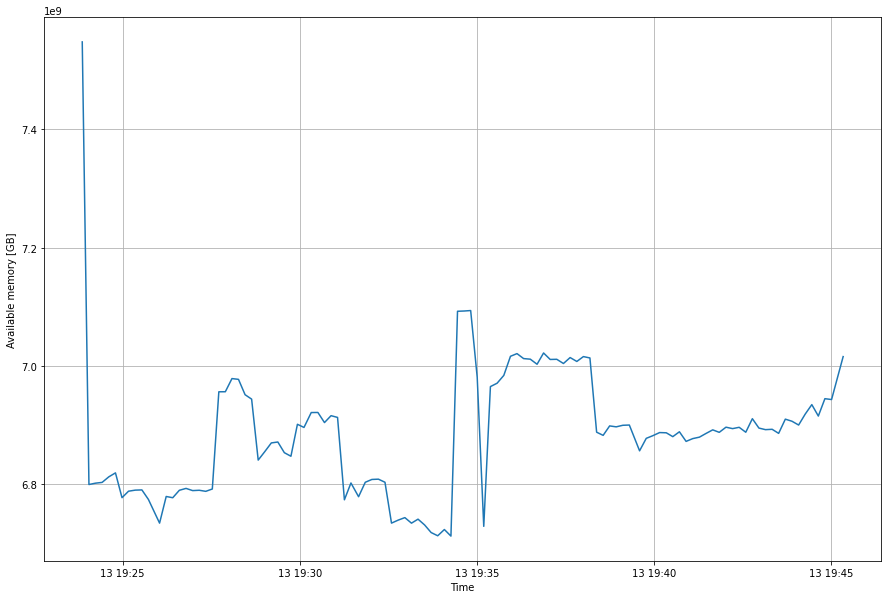

In [38]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

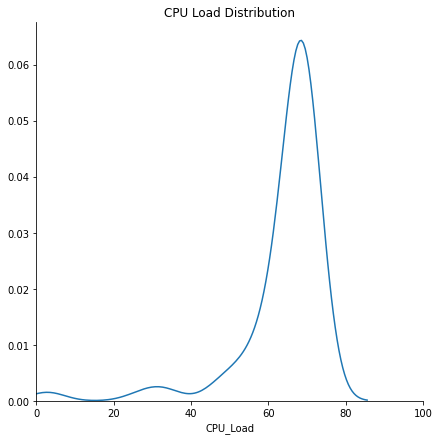

In [39]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

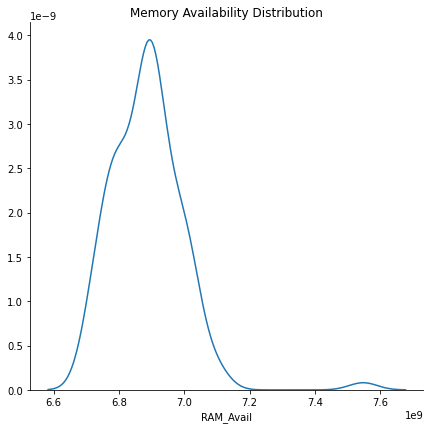

In [40]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [41]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-13 19:23:52.687654,511531500,1.000000,0.875000,0.933333,"[0.7788707204905467, 0.856114272442225, 0.8571...",7,0,1,8,"[(788.0, 192.0, 855.0, 283.0), (178.0, 146.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-13 19:23:53.057154,364864300,0.000000,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-13 19:23:53.396653,332834600,1.000000,1.000000,1.000000,"[0.8003018108651911, 0.740495867768595]",2,0,0,2,"[(461.0, 41.0, 498.0, 88.0), (553.0, 115.0, 60...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-13 19:23:53.856656,340196600,0.928571,0.209677,0.342105,"[0.7471819645732689, 0.6402116402116402, 0.731...",13,1,49,62,"[(288.0, 436.0, 319.0, 468.0), (259.0, 500.0, ...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-13 19:23:54.214156,338710200,1.000000,1.000000,1.000000,"[0.8104374520337683, 0.7985791893021312, 0.816...",8,0,0,8,"[(789.0, 61.0, 833.0, 117.0), (494.0, 84.0, 53...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-13 19:45:08.682653,340136300,1.000000,1.000000,1.000000,[0.873341375150784],1,0,0,1,"[(452.0, 130.0, 584.0, 327.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-13 19:45:09.026155,336850300,1.000000,1.000000,1.000000,"[0.8444463941042288, 0.767890248424175]",2,0,0,2,"[(713.0, 411.0, 796.0, 544.0), (330.0, 411.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-13 19:45:09.440656,342932000,1.000000,1.000000,1.000000,"[0.8022284122562674, 0.8301886792452831, 0.892...",27,0,0,27,"[(919.0, 360.0, 954.0, 400.0), (521.0, 303.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-13 19:45:09.796655,340456900,1.000000,1.000000,1.000000,"[0.7795603089720736, 0.8694652098907418, 0.847...",7,0,0,7,"[(856.0, 77.0, 897.0, 141.0), (579.0, 73.0, 61...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [42]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,3.460327e+08,0.876796,0.766028,0.796073,5.738066,1.520769,6.570676,12.308741
std,1.132760e+07,0.262769,0.324919,0.298271,13.160355,9.420892,31.293749,39.822258
min,3.312651e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.404127e+08,0.900000,0.545455,0.666667,1.000000,0.000000,0.000000,1.000000
50%,3.426753e+08,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000
75%,3.461702e+08,1.000000,1.000000,1.000000,5.000000,0.000000,3.000000,9.000000
max,5.115315e+08,1.000000,1.000000,1.000000,261.000000,244.000000,590.000000,709.000000


In [43]:
df_ap

,Confidence,TP_FP
0,0.999995,TP
1,0.999993,TP
2,0.999991,TP
3,0.999991,TP
4,0.999991,TP
...,...,...
23412,0.500107,FP
23413,0.500092,FP
23414,0.500066,FP
23415,0.500064,TP


In [44]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [45]:
df_ap

,Confidence,TP_FP,Precision,Recall
0,0.999995,TP,1.000000,0.000025
1,0.999993,TP,1.000000,0.000050
2,0.999991,TP,1.000000,0.000076
3,0.999991,TP,1.000000,0.000101
4,0.999991,TP,1.000000,0.000126
...,...,...,...,...
23412,0.500107,FP,0.790544,0.466128
23413,0.500092,FP,0.790510,0.466128
23414,0.500066,FP,0.790476,0.466128
23415,0.500064,TP,0.790485,0.466153


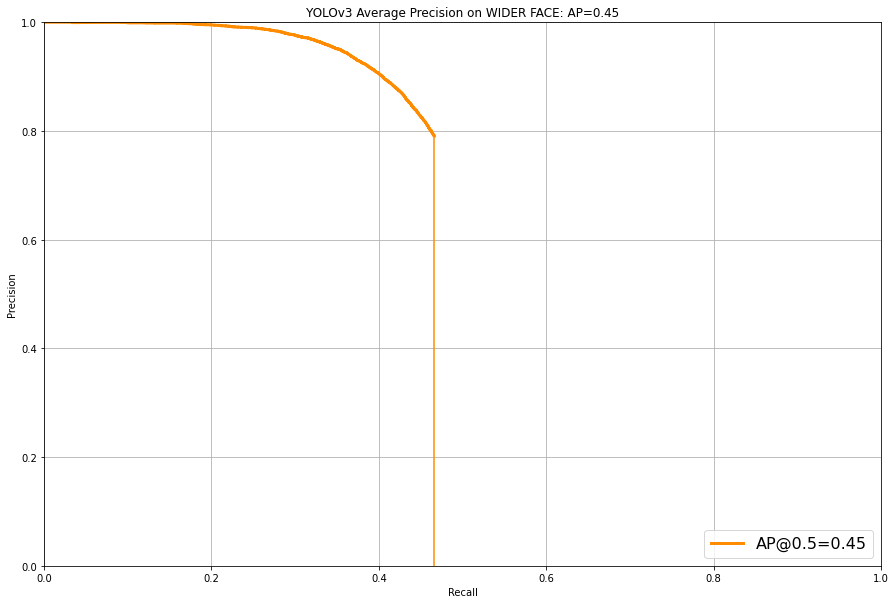

In [46]:
ap = calc_ap(df_ap)

plt.plot(df_ap['Recall'], df_ap['Precision'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
plt.axvline(x = df_ap['Recall'][df_ap.index[-1]], ymax=df_ap['Precision'][df_ap.index[-1]], color = "darkorange")
plt.xlim(0, 1.00)
plt.ylim(0, 1.00)

plt.title('YOLOv3 Average Precision on WIDER FACE: AP=%.2f' % ap)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right", prop={'size': 16})
plt.grid(True)

plt.show()